## Download

In [23]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 72.6 MB/s eta 0:00:00:00:0100:01
  Obtaining dependency information for python-crfsuite>=0.8.3 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.0 MB/s eta 0:00:00


# Import libraries

In [24]:
import re
import ast
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam
from torchtext.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pyvi import ViTokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# pre-processing

In [25]:
def normalize(text):
    t = text.replace('\n', ' ')
    t = t.lower()
    return t

def delete_hashtag(text):
    return re.sub(r'#\w+', '', text)

def delete_link(text):
    return re.sub(r'http\S+', '', text)

def remove_emojis(text):
    emoj = re.compile(r"""[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251\U0001f926-\U0001f937\U00010000-\U0010ffff\u200d\u23cf\u23e9\u231a\ufe0f\u3030-]+(?<!\n)""", re.UNICODE)
    return re.sub(emoj, '', text)

def encode_number(text):
    t = text.split(' ')
    t = map(lambda x: '<number>' if bool(re.match(r'^[0-9]+(\.[0-9]+)?$', x)) else x, t)
    return ' '.join(t)

def delete_onelen_token(text):
    t = text.split(' ')
    t = filter(lambda x: len(x)>1, t)
    return ' '.join(t)

def preprocessing(text):
    t = normalize(text)
    t = delete_hashtag(t)
    t = delete_link(t)
    t = remove_emojis(t)
    t = ViTokenizer.tokenize(t)
    t = encode_number(t)
    t = delete_onelen_token(t)
    return t

#Model and Training

In [6]:
%cd /kaggle/working/

/kaggle/working


## Define class dataset

In [7]:
class HashTag_Dataset(Dataset):
  def __init__(self, root, max_length=250):
    super(HashTag_Dataset, self).__init__()
    self.classes = ['#Q&A', '#cv', '#data', '#deep_learning', '#machine_learning', '#math', '#nlp', '#python', '#sharing']
    text, labels = [], []

    df = pd.read_csv(root, encoding='utf-8-sig')
    texts = df['text']
    labels = df["label"]
    self.texts = texts
    self.labels = labels
    self.vocab = self.make_vocab(texts)
    self.max_length = max_length
  def make_vocab(self, texts):
    vocab = dict()
    for text in texts:
      words = text.split()
      for word in words:
        if word not in vocab:
          vocab[word] = 1
        else:
          vocab[word] += 1
    vocab = list(dict(filter(lambda x: x[1]>3, vocab.items())).keys())
    vocab.append('<UNK>')
    vocab.append('<PAD>')
    return vocab
  def encode_text(self, text):
    words = text.split()
    if len(words) > self.max_length:
      words = words[:self.max_length]
    else:
      words += ['<PAD>']*(self.max_length-len(words))
    enc = [self.vocab.index(w) if w in self.vocab else self.vocab.index('<UNK>') for w in words]
    return enc
  def encode_label(self, label):
    enc = ast.literal_eval(label)
    enc = [1 if l in enc else 0 for l in self.classes]
    return enc
  def __len__(self):
    return len(self.labels)

  def len_vocab(self):
    return len(self.vocab)

  def num_classes(self):
    return len(self.classes)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encode = self.encode_text(text)
    label = self.encode_label(label)
    encode = torch.tensor(encode, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float32)
    return encode, label

## Create the model

In [8]:
class HashtagRecommendation(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_labels):
    super(HashtagRecommendation, self).__init__()
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, num_labels)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, _ = self.lstm(embeds)
    # Select the last output of LSTM layer
    lstm_out = lstm_out[:, -1, :]
    x = self.relu(self.fc1(lstm_out))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    logits = self.fc3(x)
    probs = self.sigmoid(logits)
    return probs

# define metrics

In [9]:
def accuracy(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]
def Recall(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_true[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
  return temp/ y_true.shape[0]
def Precision(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_pred[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
  return temp/ y_true.shape[0]
def F1Measure(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
          continue
      temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
  return temp/ y_true.shape[0]

# Training

In [10]:
train_set = HashTag_Dataset(root = "/kaggle/input/cs1144/train_data.csv")
test_set = HashTag_Dataset(root = "/kaggle/input/cs1144/test_data.csv")
test_loader = DataLoader(test_set, batch_size=2)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
num_epochs = 300

In [14]:
model = HashtagRecommendation(embedding_dim=100,hidden_dim=256,num_labels=train_set.num_classes(), vocab_size=train_set.len_vocab())
model = model.to(device)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.0001)
num_iters = len(train_loader)

In [15]:
best_acc = 0
trainingEpoch_loss = []
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, colour='green')
    step_loss = []

    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)

        # forward
        outputs = model(texts)
        loss_value = criterion(outputs, labels)  # Find the loss

        # backward
        optimizer.zero_grad() # clear the gradients
        loss_value.backward() # calculate gradients
        optimizer.step() # update weights

        # Calculate loss
        progress_bar.set_description("Epoch {}/{}. Iteration {}/{}. Loss {:.5f}".format(epoch+1, num_epochs, iter+1, num_iters, loss_value.item()))
        step_loss.append(loss_value.item())
    trainingEpoch_loss.append(np.array(step_loss).mean())

    # evaluate
    model.eval()
    y_true = []
    y_pred = []

    test_progress_bar = tqdm(test_loader, colour='green')
    with torch.no_grad():
        for iter, (texts, labels) in enumerate(test_progress_bar):
            texts = texts.to(device)
            labels = labels.to(dtype=torch.float).to(device)
            outputs = np.array(model(texts).tolist())
            y_pred.extend((outputs >= 0.5).astype(np.float32))
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy(y_true, y_pred)

    print(f"Accuracy: {acc}")

    if acc > best_acc:
        best_acc = acc
        print(f"Saving model at epoch {epoch}")
        torch.save(model, f'/kaggle/working//best_model_epoch_{epoch}.pth')

100%|██████████| 117/117 [00:01<00:00, 76.35it/s]


Accuracy: 0.2274623524623525
Saving model at epoch 0


100%|██████████| 117/117 [00:01<00:00, 78.09it/s]


Accuracy: 0.2237586487586488


100%|██████████| 117/117 [00:01<00:00, 74.95it/s]


Accuracy: 0.24715099715099723
Saving model at epoch 2


100%|██████████| 117/117 [00:01<00:00, 77.90it/s]


Accuracy: 0.24498371998372007


100%|██████████| 117/117 [00:01<00:00, 77.91it/s]


Accuracy: 0.23786121286121287


100%|██████████| 117/117 [00:01<00:00, 77.65it/s]


Accuracy: 0.26068376068376076
Saving model at epoch 5


100%|██████████| 117/117 [00:01<00:00, 78.11it/s]


Accuracy: 0.2636752136752138
Saving model at epoch 6


100%|██████████| 117/117 [00:01<00:00, 77.64it/s]


Accuracy: 0.27685185185185196
Saving model at epoch 7


100%|██████████| 117/117 [00:01<00:00, 73.59it/s]


Accuracy: 0.26545584045584053


100%|██████████| 117/117 [00:01<00:00, 77.87it/s]


Accuracy: 0.27435897435897444


100%|██████████| 117/117 [00:01<00:00, 77.98it/s]


Accuracy: 0.2779914529914531
Saving model at epoch 10


100%|██████████| 117/117 [00:01<00:00, 76.40it/s]


Accuracy: 0.2829772079772081
Saving model at epoch 11


100%|██████████| 117/117 [00:01<00:00, 77.35it/s]


Accuracy: 0.2790598290598292


100%|██████████| 117/117 [00:01<00:00, 78.28it/s]


Accuracy: 0.2822649572649574


100%|██████████| 117/117 [00:01<00:00, 78.27it/s]


Accuracy: 0.2165954415954416


100%|██████████| 117/117 [00:01<00:00, 77.68it/s]


Accuracy: 0.29337606837606844
Saving model at epoch 15


100%|██████████| 117/117 [00:01<00:00, 77.88it/s]


Accuracy: 0.2171652421652422


100%|██████████| 117/117 [00:01<00:00, 77.98it/s]


Accuracy: 0.21944444444444444


100%|██████████| 117/117 [00:01<00:00, 76.64it/s]


Accuracy: 0.22122507122507123


100%|██████████| 117/117 [00:01<00:00, 78.45it/s]


Accuracy: 0.21374643874643875


100%|██████████| 117/117 [00:01<00:00, 78.16it/s]


Accuracy: 0.26745014245014276


100%|██████████| 117/117 [00:01<00:00, 78.35it/s]


Accuracy: 0.29772079772079774
Saving model at epoch 21


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.29985754985754987
Saving model at epoch 22


100%|██████████| 117/117 [00:01<00:00, 74.53it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 76.17it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 78.32it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 78.28it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 77.62it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 77.66it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.78it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 77.81it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 78.20it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 78.02it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 75.97it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 78.25it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 75.02it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 76.53it/s]


Accuracy: 0.30128205128205127
Saving model at epoch 37


100%|██████████| 117/117 [00:01<00:00, 77.23it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 77.81it/s]


Accuracy: 0.2987891737891738


100%|██████████| 117/117 [00:01<00:00, 73.71it/s]


Accuracy: 0.29914529914529914


100%|██████████| 117/117 [00:01<00:00, 78.31it/s]


Accuracy: 0.2985754985754986


100%|██████████| 117/117 [00:01<00:00, 77.94it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 70.20it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.09it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.58it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 75.34it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.94it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 78.14it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 76.83it/s]


Accuracy: 0.2987891737891738


100%|██████████| 117/117 [00:01<00:00, 76.98it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.70it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.02it/s]


Accuracy: 0.29772079772079774


100%|██████████| 117/117 [00:01<00:00, 78.13it/s]


Accuracy: 0.29700854700854695


100%|██████████| 117/117 [00:01<00:00, 78.11it/s]


Accuracy: 0.0576923076923077


100%|██████████| 117/117 [00:01<00:00, 78.05it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 76.82it/s]


Accuracy: 0.0028490028490028487


100%|██████████| 117/117 [00:01<00:00, 78.13it/s]


Accuracy: 0.05591168091168092


100%|██████████| 117/117 [00:01<00:00, 77.90it/s]


Accuracy: 0.16980056980056982


100%|██████████| 117/117 [00:01<00:00, 77.69it/s]


Accuracy: 0.16908831908831906


100%|██████████| 117/117 [00:01<00:00, 78.56it/s]


Accuracy: 0.07300569800569802


100%|██████████| 117/117 [00:01<00:00, 78.16it/s]


Accuracy: 0.05733618233618234


100%|██████████| 117/117 [00:01<00:00, 76.75it/s]


Accuracy: 0.16837606837606836


100%|██████████| 117/117 [00:01<00:00, 76.02it/s]


Accuracy: 0.05662393162393163


100%|██████████| 117/117 [00:01<00:00, 78.17it/s]


Accuracy: 0.2592592592592596


100%|██████████| 117/117 [00:01<00:00, 77.71it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 77.58it/s]


Accuracy: 0.26103988603988637


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.2592592592592596


100%|██████████| 117/117 [00:01<00:00, 77.35it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 75.91it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 77.42it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 77.29it/s]


Accuracy: 0.26032763532763564


100%|██████████| 117/117 [00:01<00:00, 75.17it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 76.87it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 76.73it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 75.74it/s]


Accuracy: 0.30128205128205127


100%|██████████| 117/117 [00:01<00:00, 77.68it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.78it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.55it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.87it/s]


Accuracy: 0.301994301994302
Saving model at epoch 80


100%|██████████| 117/117 [00:01<00:00, 78.20it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 76.20it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.53it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.85it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.04it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 77.70it/s]


Accuracy: 0.29985754985754987


100%|██████████| 117/117 [00:01<00:00, 76.79it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.03it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.30it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.00it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.37it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.82it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 75.25it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.08it/s]


Accuracy: 0.30270655270655267
Saving model at epoch 94


100%|██████████| 117/117 [00:01<00:00, 77.92it/s]


Accuracy: 0.2987891737891738


100%|██████████| 117/117 [00:01<00:00, 75.18it/s]


Accuracy: 0.30270655270655267


100%|██████████| 117/117 [00:01<00:00, 77.35it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.29it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 75.13it/s]


Accuracy: 0.30306267806267806
Saving model at epoch 99


100%|██████████| 117/117 [00:01<00:00, 77.03it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.20it/s]


Accuracy: 0.30306267806267806


100%|██████████| 117/117 [00:01<00:00, 77.00it/s]


Accuracy: 0.30306267806267806


100%|██████████| 117/117 [00:01<00:00, 77.51it/s]


Accuracy: 0.30377492877492873
Saving model at epoch 104


100%|██████████| 117/117 [00:01<00:00, 77.80it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.34it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.01it/s]


Accuracy: 0.3087606837606838
Saving model at epoch 107


100%|██████████| 117/117 [00:01<00:00, 77.84it/s]


Accuracy: 0.30092592592592593


100%|██████████| 117/117 [00:01<00:00, 77.92it/s]


Accuracy: 0.30092592592592593


100%|██████████| 117/117 [00:01<00:00, 74.79it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 77.91it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 76.28it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 73.38it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 77.18it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 76.94it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.91it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 78.27it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 77.90it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.92it/s]


Accuracy: 0.3044871794871794


100%|██████████| 117/117 [00:01<00:00, 78.28it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.75it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.77it/s]


Accuracy: 0.30306267806267806


100%|██████████| 117/117 [00:01<00:00, 78.02it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.03it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 76.65it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.98it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.97it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.95it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.30it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.42it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.88it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 76.95it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.96it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.78it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 73.06it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 74.68it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.01it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.84it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.65it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.28it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.02it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 78.38it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.86it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.56it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 74.77it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.06it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 73.86it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 74.91it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 77.14it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 72.00it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 77.45it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 75.68it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 77.81it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 78.07it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.41it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.53it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 77.78it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 77.66it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 76.63it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 77.02it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.84it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.97it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.70it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.13it/s]


Accuracy: 0.26759259259259294


100%|██████████| 117/117 [00:01<00:00, 76.30it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.51it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.54it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 77.63it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.02it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 78.44it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 76.64it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 76.69it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 77.24it/s]


Accuracy: 0.2647435897435901


100%|██████████| 117/117 [00:01<00:00, 77.11it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.83it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 78.16it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.81it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 74.22it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.86it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.71it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.43it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.77it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.73it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 71.99it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 76.72it/s]


Accuracy: 0.3009259259259259


100%|██████████| 117/117 [00:01<00:00, 76.73it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.43it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.92it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 78.03it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.77it/s]


Accuracy: 0.25925925925925963


100%|██████████| 117/117 [00:01<00:00, 77.58it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.85it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 73.79it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.76it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 76.87it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 76.39it/s]


Accuracy: 0.3005698005698006


100%|██████████| 117/117 [00:01<00:00, 77.99it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 77.77it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.39it/s]


Accuracy: 0.29950142450142453


100%|██████████| 117/117 [00:01<00:00, 78.08it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 77.83it/s]


Accuracy: 0.3009259259259259


100%|██████████| 117/117 [00:01<00:00, 74.55it/s]


Accuracy: 0.3009259259259259


100%|██████████| 117/117 [00:01<00:00, 78.17it/s]


Accuracy: 0.3027065527065526


100%|██████████| 117/117 [00:01<00:00, 77.70it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 75.43it/s]


Accuracy: 0.24857549857549896


100%|██████████| 117/117 [00:01<00:00, 77.55it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.61it/s]


Accuracy: 0.26616809116809154


100%|██████████| 117/117 [00:01<00:00, 77.13it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 76.09it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.79it/s]


Accuracy: 0.3016381766381766


100%|██████████| 117/117 [00:01<00:00, 78.16it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 75.91it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.84it/s]


Accuracy: 0.30306267806267806


100%|██████████| 117/117 [00:01<00:00, 76.38it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.03it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.54it/s]


Accuracy: 0.30341880341880334


100%|██████████| 117/117 [00:01<00:00, 77.89it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 77.73it/s]


Accuracy: 0.301994301994302


100%|██████████| 117/117 [00:01<00:00, 75.17it/s]


Accuracy: 0.3014245014245014


100%|██████████| 117/117 [00:01<00:00, 75.72it/s]


Accuracy: 0.2572649572649576


100%|██████████| 117/117 [00:01<00:00, 76.91it/s]


Accuracy: 0.2572649572649576


100%|██████████| 117/117 [00:01<00:00, 77.67it/s]


Accuracy: 0.2572649572649576


100%|██████████| 117/117 [00:01<00:00, 77.95it/s]


Accuracy: 0.2586894586894591


100%|██████████| 117/117 [00:01<00:00, 78.09it/s]


Accuracy: 0.2572649572649576


100%|██████████| 117/117 [00:01<00:00, 77.62it/s]


Accuracy: 0.25925925925925963


100%|██████████| 117/117 [00:01<00:00, 77.40it/s]


Accuracy: 0.2571225071225075


100%|██████████| 117/117 [00:01<00:00, 77.60it/s]


Accuracy: 0.2585470085470089


100%|██████████| 117/117 [00:01<00:00, 78.27it/s]


Accuracy: 0.2571225071225075


100%|██████████| 117/117 [00:01<00:00, 76.99it/s]


Accuracy: 0.2610398860398864


100%|██████████| 117/117 [00:01<00:00, 77.03it/s]


Accuracy: 0.3028490028490029


100%|██████████| 117/117 [00:01<00:00, 77.90it/s]


Accuracy: 0.2606837606837611


100%|██████████| 117/117 [00:01<00:00, 76.56it/s]


Accuracy: 0.2606837606837611


100%|██████████| 117/117 [00:01<00:00, 77.68it/s]


Accuracy: 0.2564102564102568


100%|██████████| 117/117 [00:01<00:00, 77.58it/s]


Accuracy: 0.2564102564102568


100%|██████████| 117/117 [00:01<00:00, 77.02it/s]


Accuracy: 0.25783475783475823


100%|██████████| 117/117 [00:01<00:00, 77.31it/s]


Accuracy: 0.25783475783475823


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.25819088319088357


100%|██████████| 117/117 [00:01<00:00, 75.97it/s]


Accuracy: 0.06125356125356125


100%|██████████| 117/117 [00:01<00:00, 77.34it/s]


Accuracy: 0.06018518518518519


100%|██████████| 117/117 [00:01<00:00, 76.98it/s]


Accuracy: 0.06303418803418805


100%|██████████| 117/117 [00:01<00:00, 76.58it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 78.08it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 76.67it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 77.37it/s]


Accuracy: 0.062464387464387476


100%|██████████| 117/117 [00:01<00:00, 77.27it/s]


Accuracy: 0.0638888888888889


100%|██████████| 117/117 [00:01<00:00, 77.46it/s]


Accuracy: 0.06303418803418805


100%|██████████| 117/117 [00:01<00:00, 78.14it/s]


Accuracy: 0.06103988603988604


100%|██████████| 117/117 [00:01<00:00, 76.44it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 76.69it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 76.25it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 77.96it/s]


Accuracy: 0.0638888888888889


100%|██████████| 117/117 [00:01<00:00, 77.95it/s]


Accuracy: 0.06331908831908832


100%|██████████| 117/117 [00:01<00:00, 77.75it/s]


Accuracy: 0.2611823361823366


100%|██████████| 117/117 [00:01<00:00, 77.43it/s]


Accuracy: 0.06246438746438747


100%|██████████| 117/117 [00:01<00:00, 76.39it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.06103988603988604


100%|██████████| 117/117 [00:01<00:00, 77.47it/s]


Accuracy: 0.06125356125356125


100%|██████████| 117/117 [00:01<00:00, 77.50it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 78.05it/s]


Accuracy: 0.24465811965812


100%|██████████| 117/117 [00:01<00:00, 78.08it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 74.99it/s]


Accuracy: 0.062108262108262105


100%|██████████| 117/117 [00:01<00:00, 77.31it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 76.58it/s]


Accuracy: 0.062108262108262105


100%|██████████| 117/117 [00:01<00:00, 75.76it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 77.37it/s]


Accuracy: 0.06246438746438747


100%|██████████| 117/117 [00:01<00:00, 78.15it/s]


Accuracy: 0.06018518518518519


100%|██████████| 117/117 [00:01<00:00, 77.30it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 74.81it/s]


Accuracy: 0.06246438746438747


100%|██████████| 117/117 [00:01<00:00, 77.04it/s]


Accuracy: 0.06103988603988604


100%|██████████| 117/117 [00:01<00:00, 77.72it/s]


Accuracy: 0.2586894586894591


100%|██████████| 117/117 [00:01<00:00, 77.98it/s]


Accuracy: 0.2586894586894591


100%|██████████| 117/117 [00:01<00:00, 78.10it/s]


Accuracy: 0.06160968660968662


100%|██████████| 117/117 [00:01<00:00, 77.41it/s]


Accuracy: 0.062464387464387476


100%|██████████| 117/117 [00:01<00:00, 75.99it/s]


Accuracy: 0.2572649572649576


100%|██████████| 117/117 [00:01<00:00, 76.73it/s]


Accuracy: 0.062108262108262105


100%|██████████| 117/117 [00:01<00:00, 77.64it/s]


Accuracy: 0.06103988603988604


100%|██████████| 117/117 [00:01<00:00, 77.45it/s]


Accuracy: 0.061965811965811975


100%|██████████| 117/117 [00:01<00:00, 78.16it/s]


Accuracy: 0.0608974358974359


100%|██████████| 117/117 [00:01<00:00, 76.90it/s]


Accuracy: 0.062108262108262105


100%|██████████| 117/117 [00:01<00:00, 78.40it/s]


Accuracy: 0.06103988603988604


100%|██████████| 117/117 [00:01<00:00, 78.68it/s]


Accuracy: 0.062464387464387476


100%|██████████| 117/117 [00:01<00:00, 77.82it/s]


Accuracy: 0.062108262108262105


100%|██████████| 117/117 [00:01<00:00, 76.01it/s]


Accuracy: 0.0638888888888889


100%|██████████| 117/117 [00:01<00:00, 77.76it/s]


Accuracy: 0.06103988603988605


100%|██████████| 117/117 [00:01<00:00, 77.87it/s]


Accuracy: 0.06353276353276353


100%|██████████| 117/117 [00:01<00:00, 77.98it/s]


Accuracy: 0.06125356125356125


100%|██████████| 117/117 [00:01<00:00, 77.46it/s]


Accuracy: 0.06267806267806268


100%|██████████| 117/117 [00:01<00:00, 76.61it/s]


Accuracy: 0.06125356125356125


100%|██████████| 117/117 [00:01<00:00, 77.12it/s]


Accuracy: 0.06267806267806268


100%|██████████| 117/117 [00:01<00:00, 77.77it/s]

Accuracy: 0.06353276353276353


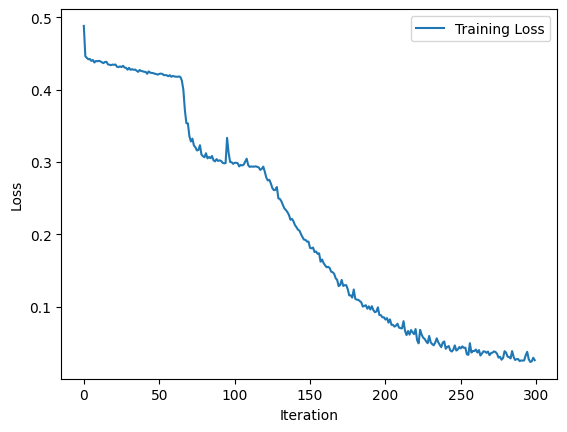

In [17]:
# Plot the loss history
plt.plot(trainingEpoch_loss, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/training_loss_plot.png')
plt.show()

## Evaluate on test set

In [18]:
model = torch.load('/kaggle/working/best_model_epoch_107.pth')
model.eval()
y_true = []
y_pred = []
progress_bar = tqdm(test_loader, colour='yellow')
with torch.no_grad():
    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)
        outputs = np.array(model(texts).tolist())
        y_pred.extend((outputs >= 0.5).astype(np.float32))
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = accuracy(y_true, y_pred)
precision = Precision(y_true, y_pred)
recall = Recall(y_true, y_pred)
F1_score = F1Measure(y_true, y_pred)

# Define the table format
table_format = "{:<12} {:<10}"

# Print the title
print("Evaluate on test set")

# Print the table header
print(table_format.format("Metric", "Value"))
print("-" * 22)  # Separating line

# Print rows with metrics
print(table_format.format("Accuracy:", f"{acc:.2%}"))
print(table_format.format("Precision:", f"{precision:.2%}"))
print(table_format.format("Recall:", f"{recall:.2%}"))
print(table_format.format("F1 Score:", f"{F1_score:.2%}"))

100%|██████████| 117/117 [00:01<00:00, 77.85it/s]

Evaluate on test set
Metric       Value     
----------------------
Accuracy:    30.88%    
Precision:   63.60%    
Recall:      31.05%    
F1 Score:    40.66%    


## Import libraries

#Testing

In [19]:
#load model
model = torch.load('/kaggle/working/best_model_epoch_107.pth')
print(model)

HashtagRecommendation(
  (word_embeddings): Embedding(2180, 100)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [20]:
sentence = input()

 tôi có tài liệu machine learning muốn chia sẻ


In [26]:
test = preprocessing(sentence)
test = train_set.encode_text(sentence)
test = ToTensor()(test)[None, :]
test = test.to(device)
pred = model(test)[0].tolist()
pred = [train_set.classes[i] for i in range(len(pred)) if pred[i]>0.5]
print("Predict label: ", *pred)

Predict label:  #sharing
